# PPI Graph Builder v.0.1

Вход - поисковый запрос в базу медицинских данных $Medline$  
Выход - граф PPI (protein-protein interactions) по данному запросу, визуализиованный в виде изображения + в формате PDF

Необходимые пакеты:  
<i>numpy  
biopython  
bs4  
igraph  
py2cytoscape</i>

## Часть 1: Майнинг medline abstracts

Здесь мы майним medline abstracts, которые потом будем прогонять Jens Tagger, чтобы пометить белки.  
Вход - поисковый запрос $term$  
Выход - список MEDLINE abstracts (переменная $abstracts$)  
Для работы необходим модуль $Biopython$

In [2]:
term_to_search = input()

cancer


In [4]:
%%time
from Bio import Entrez

handle = Entrez.esearch(db="pubmed",
                            sort='relevance',
                            term = term_to_search,
                            retmax = 1000) #max number of abstracts to consider

record = Entrez.read(handle)
handle.close()
idlist = record["IdList"]

from Bio import Medline
handle = Entrez.efetch(db="pubmed",
                       id=idlist,
                       rettype="medline",
                       retmode="text")
records = Medline.parse(handle)

records = list(records)

Wall time: 16.8 s


Опыт показывает, что некоторые записи в формате MEDLINE не имеют abstract'a, поэтому мы такие статьи будем пропускать:

In [7]:
abstracts = []
k = 0
for i in range(len(records)):
    try:
        abstracts.append(records[i]['AB'])
    except:
        k = k + 1
        print('problem: no abstracts for this ID found! ID =', i)

problem: no abstracts for this ID found! ID = 416


In [8]:
raw_abstracts_file = open('raw_abstracts.txt', 'w')
for abstract in abstracts:
    raw_abstracts_file.write(abstract + '\n-----\n')
raw_abstracts_file.close()

Этап получения abstracts на этом завершен.  

## Часть 2: Работаем с xml requests

Информация по данному REST API находится здесь: https://extract.jensenlab.org/

In [10]:
path_to_abstacts = 'raw_abstracts.txt'
abstracts = open(path_to_abstacts).read().split('\n-----\n')[:-1]

In [11]:
%%time
import requests
import bs4

respond_html = []

#data = {'document': text, 'entity_types': '9606', 'format':'tsv'}

url = 'http://tagger.jensenlab.org/GetHTML'

for text in abstracts:
    data = {'document': text, 'entity_types': '9606'}
    respond_html.append(requests.post(url, data = data).text)

Wall time: 1min 42s


Функция $find\_all\_proteins$:  
Вытаскиваем белки с сохранением структуры предложений.  
Что получается?  
Вход: один html-размеченный текст  
Выход: список, в котором содержатся списки белков со структурой:  

[prot_id, name_in_text, sentence_number, name_db]

In [12]:
def find_all_proteins(source):
    '''
    input: tagged html-text (FULL abstract)
    output: list of proteins
    '''
    source_2sect = source.split('<div class=\"reflect_entities\" style=\"display: none;\">')
    sentence_prot_id_and_name = []
    k = 1
    for one_sentence in source_2sect[0].split('. '):
        proteins = []
        all_text_res = bs4.BeautifulSoup(one_sentence).findAll('span')
        for one_result in all_text_res:
            if one_result.has_attr('onclick'):
                name_id = one_result.attrs['onclick'].split('\'')[1]
                name = one_result.attrs['onclick'].split('\'')[-2]
                proteins.append([name_id, name])
        if len(proteins) > 1:
            sentence_prot_id_and_name.append(proteins)
        k += 1
    
    #appending database id
    for sentence in sentence_prot_id_and_name:
        for protein in sentence:
            name_db = bs4.BeautifulSoup(source_2sect[1]).find("span", {"name": protein[0]}).text
            #try to find human protein id
            for human_id in name_db.split(';'):
                if human_id[:4] == '9606':
                    protein.append(human_id.split('.')[1])
                    break
            #if it fails, then it uses any it can find
            if len(protein) == 2:
                protein.append(name_db.split('.')[-1])
    
    return sentence_prot_id_and_name

In [13]:
%%time
all_proteins_list = [find_all_proteins(html) for html in respond_html]

Wall time: 4.18 s


## Часть 3: обработка белков

Составляем БД всех встретившихся нам белков:

In [14]:
def create_protein_DB(all_proteins_list):
    all_proteins_id = []
    for text in all_proteins_list:
        for sentence in text:
            for protein in sentence:
                all_proteins_id.append([protein[-1], protein[1]])
            
        unique_proteins_ids = []
        [unique_proteins_ids.append(idp[0]) for idp in all_proteins_id]
        unique_proteins_ids = list(set(unique_proteins_ids))
        
        id_and_protnames = []
        for one_id in unique_proteins_ids:
            names_list = []
            for pr_list in all_proteins_id:
                if one_id == pr_list[0]:
                    names_list.append(pr_list[1])
            names_list = list(set(names_list))
            id_and_protnames.append([one_id, names_list])
            
    return id_and_protnames

In [16]:
%%time
protDB = create_protein_DB(all_proteins_list)

len(protDB)

Wall time: 10.7 s


Записываем все найденные белки в файл:

In [17]:
raw_proteins_in_sentences_file = open('proteins_in_sentences.txt', 'w')
for text in all_proteins_list:
    for sentence in text:
        for protein in sentence:
            raw_proteins_in_sentences_file.write(protein[2] + '; ')
        raw_proteins_in_sentences_file.write('\n')
    raw_proteins_in_sentences_file.write('-----\n')
raw_proteins_in_sentences_file.close()

Запишем так же БД имен встреченных в текстах белков для дальнейшей их расшифровки:

In [24]:
prot_db_file = open('protDB.txt', 'w')
for unique_prot in protDB:
    prot_db_file.write(unique_prot[0] + ': ' + '; '.join(unique_prot[1]) + '\n')
prot_db_file.close()

In [26]:
#Good reading from file.
#Result: 
#list of texts, 
#each contains list of sentences, 
#each contains list of unique proteins, if there are more than 1

raw_proteins_in_sentences = open(
    'proteins_in_sentences.txt', 'r'
    ).read().split('-----\n')

proteins_from_file = []

for text in raw_proteins_in_sentences:
    in_text = []
    for sentence in text[:-1].split('\n'):
        proteins_in_sentence = list(set(sentence.split('; ')[:-1]))
        if len(proteins_in_sentence) > 1:
            in_text.append(proteins_in_sentence)
    proteins_from_file.append(in_text)

#list of all proteins from _very_structured_list_ 'proteins_from_file'
all_proteins = []
for text in proteins_from_file:
    for sent in text:
        for protein in sent:
            if protein not in all_proteins:
                all_proteins.append(protein)

In [27]:
len(all_proteins)

306

Составляем матрицу $cooc\_texts$ вида:  
Строка - все встреченные белки $all\_proteins$ в конкретном предложении  
Столбец - все содержательные предложения

In [28]:
#sentences count
import numpy as np
proteins_from_file_wo_text_structure = [protein 
                                        for sentence in proteins_from_file 
                                        for protein in sentence]

cooc_texts = np.zeros((len(proteins_from_file_wo_text_structure), len(all_proteins)))

for protein_index, protein_from_list in enumerate(all_proteins):
    for sent_index, sentence in enumerate(proteins_from_file_wo_text_structure):
        for prot_from_file in sentence:
            if prot_from_file == protein_from_list:
                cooc_texts[sent_index][protein_index] += 1

In [29]:
cooc_texts.shape

(199, 306)

In [30]:
prot_names = []
for one_id in all_proteins:
    for names in protDB:
        if names[0] == one_id:
            prot_names.append(min(names[1], key = len))
len(prot_names)

306

## Часть 4: py2cytoscape (визуализация через CyREST API) 

Необходимое условие: должен быть запущен Cytoscape, модуль py2cytoscape стучится по адресу <b>localhost:1234</b>

In [31]:
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.util_network import NetworkUtil as util
from py2cytoscape.data.style import StyleUtil as s_util
import py2cytoscape.cytoscapejs as renderer
from IPython.display import Image
#import networkx as nx
#from networkx.drawing import nx_pydot as pyd

<IPython.core.display.Javascript object>

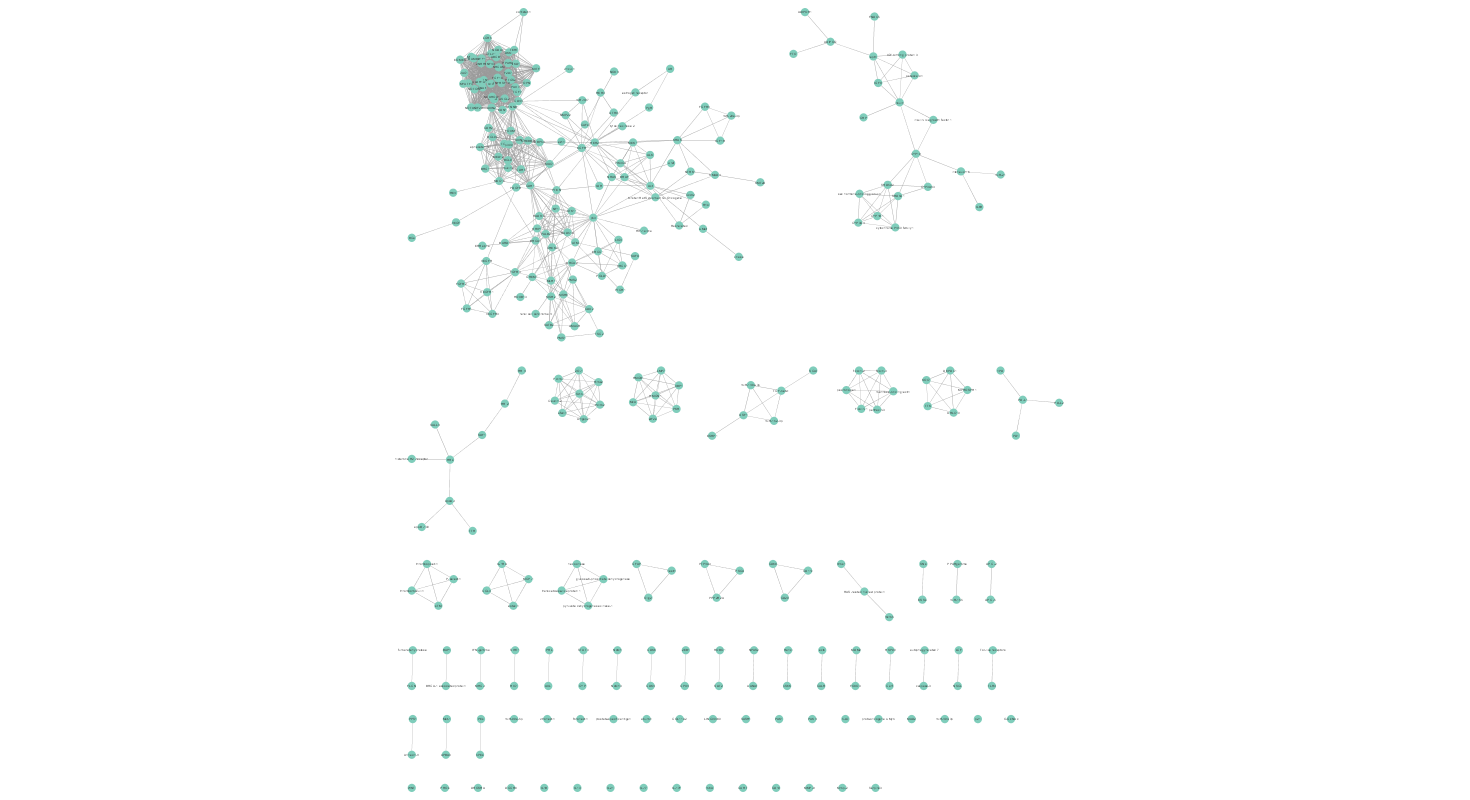

In [34]:
cy = CyRestClient()

#строим co-occurence матрицу с занулённой диагональю (чтобы в результате у нас не оказалось петель)
matrix1 = np.triu(cooc_texts.T.dot(cooc_texts), k = 1)

net1 = cy.network.create_from_ndarray(matrix1, name='Review 2', labels = prot_names)
cy.layout.apply(network=net1)

style_s2 = cy.style.create('Sample1')

cy.style.apply(style=style_s2, network=net1)
cy.layout.fit(network=net1)
Image(net1.get_png(height=800))

Экспорт графа в формате pdf

In [35]:
final_result = open('PPI_PDF_result.pdf', 'wb')
final_result.write(net1.get_pdf())
final_result.close()

Автор: Студент 4 курса ФБМФ МФТИ Тягин Илья.  
Версия предварительная и в данный момент находится в разработке.
По всем вопросам обращаться на почту tyagin.ia@phystech.edu